# NNGPT Project: Experiment Analysis and LLM Fine-tuning Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display, HTML

# Set the style for our plots
plt.style.use('fivethirtyeight')
sns.set_context("talk")

In [2]:
df = pd.read_excel('../../stat/raw_data.xlsx')

In [3]:
df.head()

,task,dataset,metric,epoch,duration,accuracy,nn,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,img-classification,celeba-gender,acc,1,4.711268e+10,0.967739,AirNet,NaN,NaN,NaN,NaN,Accuracy vs Epochs
1,img-classification,celeba-gender,acc,1,4.415546e+10,0.964432,AirNet,NaN,NaN,NaN,NaN,NaN
2,img-classification,celeba-gender,acc,1,3.954598e+11,0.963931,AirNet,NaN,NaN,NaN,NaN,NaN
3,img-classification,celeba-gender,acc,1,1.023431e+11,0.962429,AirNet,NaN,NaN,NaN,NaN,NaN
4,img-classification,celeba-gender,acc,1,1.648104e+11,0.949354,AirNet,NaN,NaN,NaN,NaN,NaN


In [4]:
# Show unique values for categorical columns
unique_models = df['nn'].unique() if 'nn' in df.columns else "Model column not found"

unique_models

array(['AirNet', 'BagNet', 'BayesianNet-1', 'BayesianNet-2',
       'BayesianNet-3', 'ComplexNet', 'ConvNeXt', 'DPN107', 'DPN131',
       'DPN68', 'DarkNet', 'DenseNet', 'Diffuser', 'EfficientNet',
       'FractalNet', 'GoogLeNet', 'ICNet', 'InceptionV3-1',
       'InceptionV3-2', 'MaxVit', 'MobileNetV2', 'MobileNetV3', 'RegNet',
       'ResNet', 'ShuffleNet', 'SqueezeNet-1', 'SqueezeNet-2',
       'SwinTransformer', 'UNet2D', 'VGG', 'VisionTransformer',
       'AirNet-777bc9dc-e6c7-4bff-8be1-a1b02adea68f', 'AirNext',
       'AirNext-41197f14-7a44-44c6-92fa-4548ef594c7b',
       'AirNext-ff05392a-e85a-463f-a97f-64d36c15c57f', 'AlexNet',
       'AlexNet-69c52339-4eac-45f1-bbfe-2c51949701f1',
       'BagNet-560341b5-15a8-4829-a8ac-ea4c7391a950',
       'BagNet-6ecd3fc7-5ce2-4876-86a6-5e8250c43d78',
       'BagNet-7e541be1-6b60-445d-bbbf-3b655eeefc9a',
       'ConvNeXt-dda5bf19-9ac1-460b-9bfd-735eec2f4904',
       'DPN131-123178c5-4ecf-4935-aa95-b04c35717048',
       'DPN131-8e6e495b-85cb

In [5]:
target_models = ['AirNet', 'AirNext', 'BagNet', 'DarkNet', 'Diffuser', 'DPN68', 'DPN131', 'DPN107', 'FractalNet', 'ICNet']

In [6]:
df_filtered = df[df['nn'].isin(target_models)]
print(f"\nFiltered data to include only the specified models. Shape: {df_filtered.shape}")


Filtered data to include only the specified models. Shape: (9399, 12)


In [7]:
df_filtered.head()

,task,dataset,metric,epoch,duration,accuracy,nn,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,img-classification,celeba-gender,acc,1,4.711268e+10,0.967739,AirNet,NaN,NaN,NaN,NaN,Accuracy vs Epochs
1,img-classification,celeba-gender,acc,1,4.415546e+10,0.964432,AirNet,NaN,NaN,NaN,NaN,NaN
2,img-classification,celeba-gender,acc,1,3.954598e+11,0.963931,AirNet,NaN,NaN,NaN,NaN,NaN
3,img-classification,celeba-gender,acc,1,1.023431e+11,0.962429,AirNet,NaN,NaN,NaN,NaN,NaN
4,img-classification,celeba-gender,acc,1,1.648104e+11,0.949354,AirNet,NaN,NaN,NaN,NaN,NaN


In [8]:
# Find the maximum number of epochs for each model
max_epochs = df_filtered.groupby('nn')['epoch'].max().reset_index()

print("\nMaximum number of epochs per model:")
max_epochs


Maximum number of epochs per model:


,nn,epoch
0,AirNet,50
1,AirNext,50
2,BagNet,50
3,DPN107,50
4,DPN131,50
5,DPN68,50
6,DarkNet,50
7,Diffuser,50
8,FractalNet,7
9,ICNet,50


In [9]:
# Find the epoch with the maximum accuracy for each model
max_accuracy = df_filtered.loc[df_filtered.groupby('nn')['accuracy'].idxmax()]

print("\nEpoch with maximum accuracy for each model:")
max_accuracy[['nn', 'epoch', 'accuracy']]


Epoch with maximum accuracy for each model:


,nn,epoch,accuracy
26791,AirNet,32,0.995000
34603,AirNext,12,0.943108
27117,BagNet,32,0.993100
28070,DPN107,5,0.954000
28303,DPN131,35,0.987800
28379,DPN68,4,0.977400
28763,DarkNet,50,0.994700
28957,Diffuser,4,0.952700
29276,FractalNet,5,0.991900
29659,ICNet,44,0.985300


In [10]:
df_early_epochs = df_filtered[df_filtered['epoch'].isin([1, 2])]
print(f"\nData from epochs 1 and 2. Shape: {df_early_epochs.shape}")


Data from epochs 1 and 2. Shape: (2151, 12)


# Merge Data for Fine-tuning

In [11]:
# Create a list to store the merged data
merged_data = []

for model in target_models:
    # Get the row with maximum accuracy for this model
    max_acc_row = max_accuracy[max_accuracy['nn'] == model].iloc[0].to_dict()
    
    # Get data from epochs 1 and 2 for this model
    early_epochs_data = df_early_epochs[df_early_epochs['nn'] == model].to_dict('records')
    
    # Create a new record with data from maximum accuracy epoch and epochs 1, 2
    for early_epoch in early_epochs_data:
        merged_record = {
            'model': model,
            'early_epoch': early_epoch['epoch'],
            'early_accuracy': early_epoch['accuracy'],
            'max_accuracy_epoch': max_acc_row['epoch'],
            'max_accuracy': max_acc_row['accuracy']
        }
        
        # Add any other relevant columns
        for col in df_filtered.columns:
            if col not in ['nn', 'epoch', 'accuracy']:
                if col in early_epoch:
                    merged_record[f'early_{col}'] = early_epoch[col]
                if col in max_acc_row:
                    merged_record[f'max_{col}'] = max_acc_row[col]
        
        merged_data.append(merged_record)

# Create a dataframe with the merged data
df_merged = pd.DataFrame(merged_data)

print("\nMerged data for fine-tuning:")
df_merged.head()


Merged data for fine-tuning:


,model,early_epoch,early_accuracy,max_accuracy_epoch,max_accuracy,early_task,max_task,early_dataset,max_dataset,early_metric,...,early_Unnamed: 7,max_Unnamed: 7,early_Unnamed: 8,max_Unnamed: 8,early_Unnamed: 9,max_Unnamed: 9,early_Unnamed: 10,max_Unnamed: 10,early_Unnamed: 11,max_Unnamed: 11
0,AirNet,1,0.967739,32,0.995,img-classification,img-classification,celeba-gender,mnist,acc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accuracy vs Epochs,NaN
1,AirNet,1,0.964432,32,0.995,img-classification,img-classification,celeba-gender,mnist,acc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AirNet,1,0.963931,32,0.995,img-classification,img-classification,celeba-gender,mnist,acc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AirNet,1,0.962429,32,0.995,img-classification,img-classification,celeba-gender,mnist,acc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AirNet,1,0.949354,32,0.995,img-classification,img-classification,celeba-gender,mnist,acc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Prepare Data for LLM Fine-tuning

In [12]:
# Create a formatted dataset suitable for LLM fine-tuning
llm_data = []

for _, row in df_merged.iterrows():
    prompt = f"Model: {row['model']}\n"
    prompt += f"Early epoch: {row['early_epoch']}\n"
    prompt += f"Early accuracy: {row['early_accuracy']:.4f}\n"
    
    # Add other early metrics if available
    for col in row.index:
        if col.startswith('early_') and col not in ['early_epoch', 'early_accuracy']:
            prompt += f"{col.replace('early_', '')}: {row[col]}\n"
    
    completion = f"Maximum accuracy: {row['max_accuracy']:.4f}\n"
    completion += f"Achieved at epoch: {row['max_accuracy_epoch']}\n"
    
    # Add other max metrics if available
    for col in row.index:
        if col.startswith('max_') and col not in ['max_accuracy', 'max_accuracy_epoch']:
            completion += f"{col.replace('max_', '')}: {row[col]}\n"
    
    llm_data.append({
        'prompt': prompt,
        'completion': completion
    })

# Create a dataframe with the LLM fine-tuning data
df_llm = pd.DataFrame(llm_data)
print("\nData prepared for LLM fine-tuning:")
display(df_llm.head())

# Save the LLM fine-tuning data to a CSV file
df_llm.to_csv('../../stat/llm_finetuning_data.csv', index=False)
print("\nSaved LLM fine-tuning data to 'llm_finetuning_data.csv'")


Data prepared for LLM fine-tuning:


,prompt,completion
0,Model: AirNet\nEarly epoch: 1\nEarly accuracy:...,Maximum accuracy: 0.9950\nAchieved at epoch: 3...
1,Model: AirNet\nEarly epoch: 1\nEarly accuracy:...,Maximum accuracy: 0.9950\nAchieved at epoch: 3...
2,Model: AirNet\nEarly epoch: 1\nEarly accuracy:...,Maximum accuracy: 0.9950\nAchieved at epoch: 3...
3,Model: AirNet\nEarly epoch: 1\nEarly accuracy:...,Maximum accuracy: 0.9950\nAchieved at epoch: 3...
4,Model: AirNet\nEarly epoch: 1\nEarly accuracy:...,Maximum accuracy: 0.9950\nAchieved at epoch: 3...



Saved LLM fine-tuning data to 'llm_finetuning_data.csv'


# Visualizations

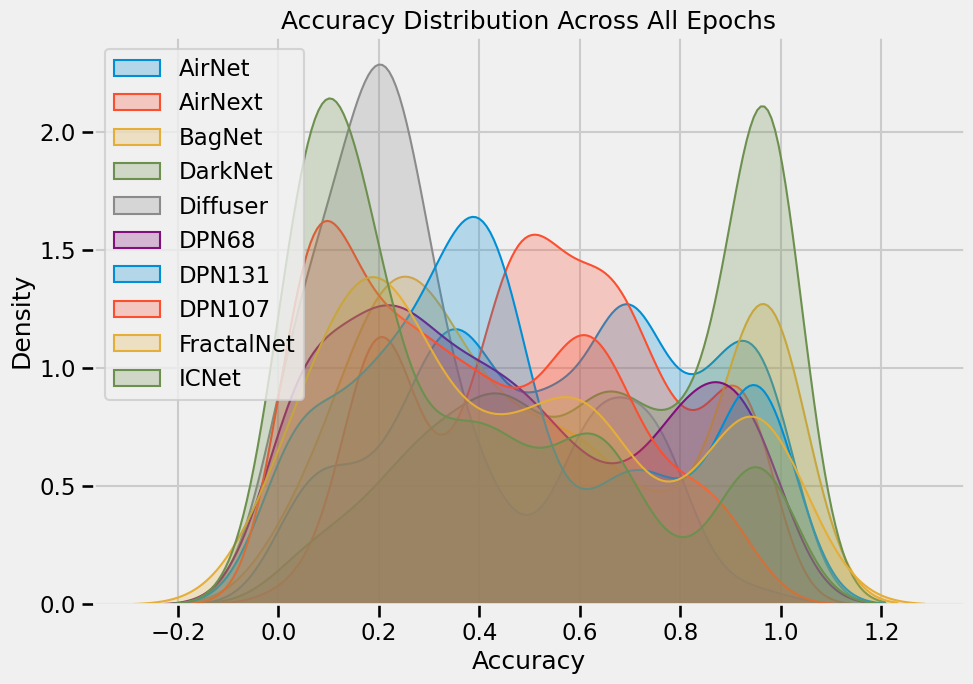

In [13]:
# Plot 1: Distribution of accuracy across all epochs for each model
plt.figure(figsize=(10, 7))
for model in target_models:
    model_data = df_filtered[df_filtered['nn'] == model]
    sns.kdeplot(model_data['accuracy'], label=model, fill=True)
plt.xlabel('Accuracy')
plt.ylabel('Density')
plt.title('Accuracy Distribution Across All Epochs')
plt.legend()
plt.grid(True)
plt.savefig('../../stat/raw/accuracy_distribution.png')
plt.show()

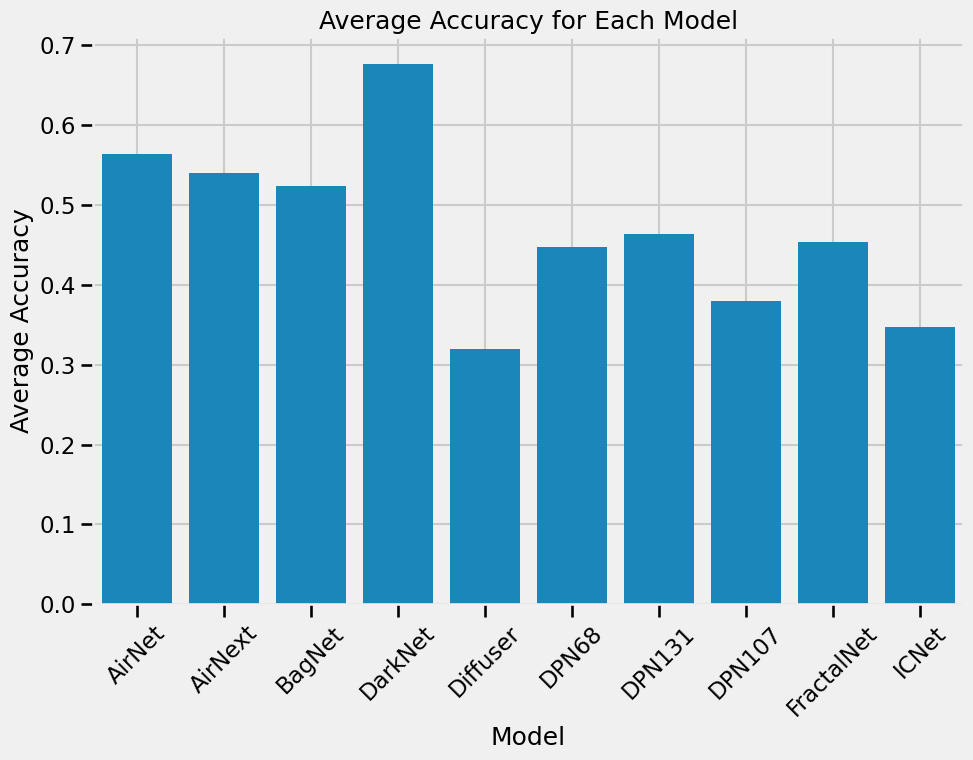

In [14]:
# Calculate average accuracy for each model
avg_accuracy = df_filtered.groupby('nn', as_index=False)['accuracy'].mean()

# Plot 2: Bar chart of average accuracy for each model
plt.figure(figsize=(10, 7))
sns.barplot(x='nn', y='accuracy', data=avg_accuracy, order=target_models)
plt.xlabel('Model')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy for Each Model')
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig('../../stat/raw/average_accuracy.png')
plt.show()

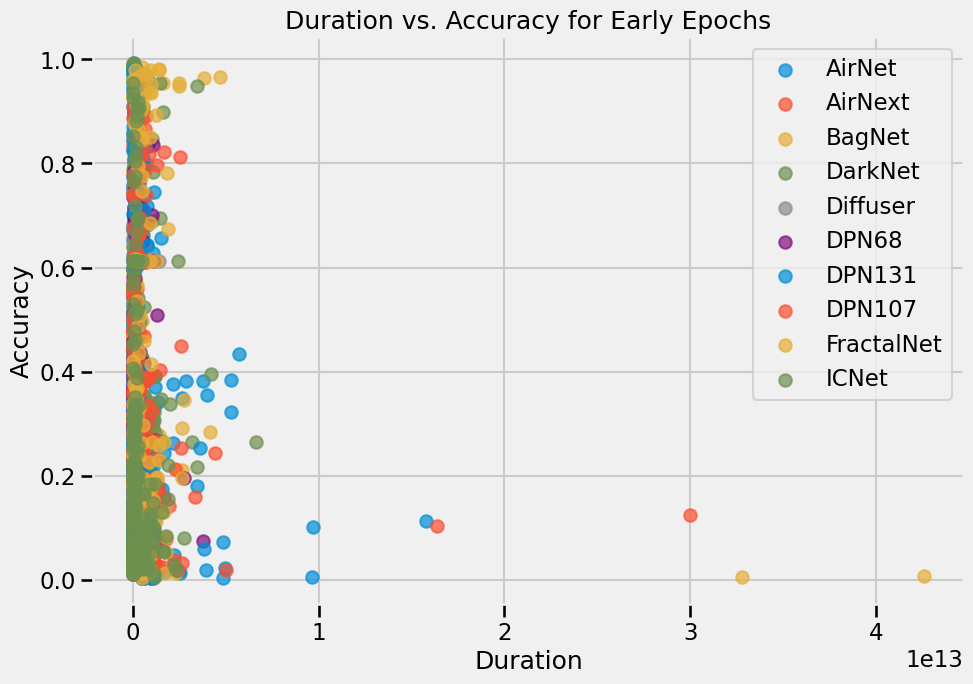

In [15]:
# Plot 3: Duration vs. accuracy for early epochs
plt.figure(figsize=(10, 7))
for model in target_models:
    model_data = df_early_epochs[df_early_epochs['nn'] == model]
    plt.scatter(model_data['duration'], model_data['accuracy'], label=model, alpha=0.7)
plt.xlabel('Duration')
plt.ylabel('Accuracy')
plt.title('Duration vs. Accuracy for Early Epochs')
plt.legend()
plt.grid(True)
plt.savefig('../../stat/raw/duration_vs_accuracy.png')
plt.show()

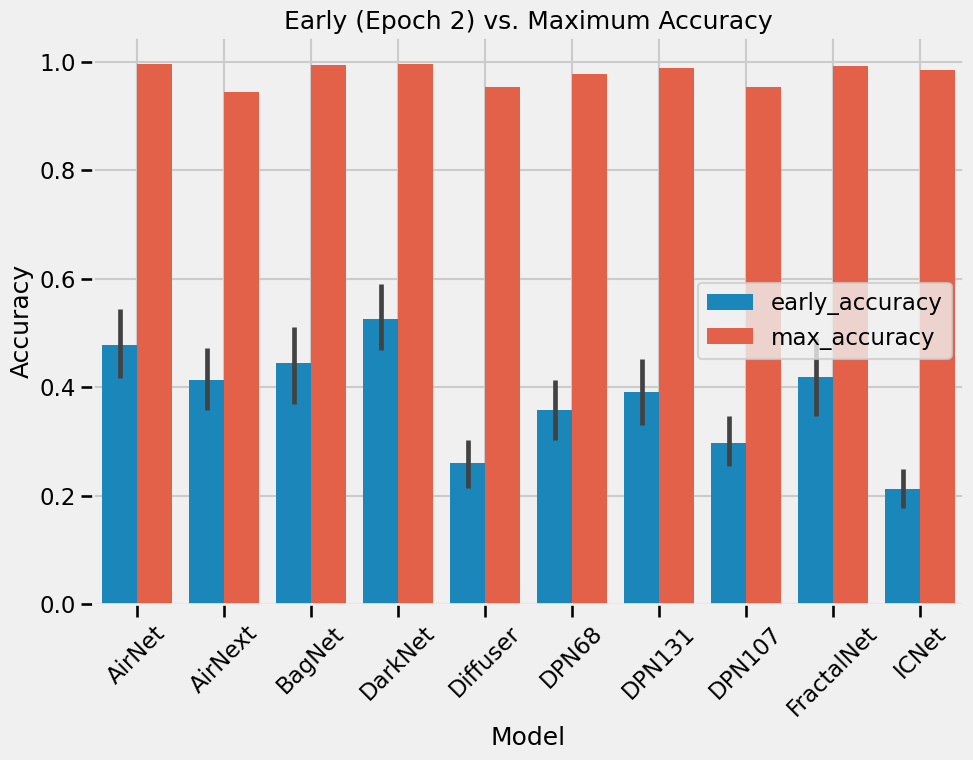

In [16]:
# Plot 4: Comparison of early and maximum accuracy
plt.figure(figsize=(10, 7))
early_vs_max = df_merged[df_merged['early_epoch'] == 2][['model', 'early_accuracy', 'max_accuracy']]
early_vs_max = early_vs_max.melt(id_vars=['model'], 
                                 value_vars=['early_accuracy', 'max_accuracy'],
                                 var_name='Metric', value_name='Accuracy')
sns.barplot(x='model', y='Accuracy', hue='Metric', data=early_vs_max, order=target_models)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Early (Epoch 2) vs. Maximum Accuracy')
plt.xticks(rotation=45)
plt.legend(title='')
plt.grid(True)
plt.savefig('../../stat/raw/early_vs_max_accuracy.png')
plt.show()

# Statistical Analysis

In [17]:
# Calculate improvement metrics
improvement_stats = df_merged[df_merged['early_epoch'] == 2].copy()
improvement_stats['accuracy_improvement'] = improvement_stats['max_accuracy'] - improvement_stats['early_accuracy']
improvement_stats['improvement_percentage'] = (improvement_stats['accuracy_improvement'] / improvement_stats['early_accuracy']) * 100

print("\nStatistical analysis of improvements:")
display(improvement_stats[['model', 'early_accuracy', 'max_accuracy', 'accuracy_improvement', 'improvement_percentage']])

# Calculate correlation between early and maximum accuracy
correlation = improvement_stats['early_accuracy'].corr(improvement_stats['max_accuracy'])
print(f"\nCorrelation between early (epoch 2) and maximum accuracy: {correlation:.4f}")


Statistical analysis of improvements:


,model,early_accuracy,max_accuracy,accuracy_improvement,improvement_percentage
28,AirNet,0.971897,0.9950,0.023103,2.377146
29,AirNet,0.971346,0.9950,0.023654,2.435224
30,AirNet,0.968891,0.9950,0.026109,2.694742
31,AirNet,0.964733,0.9950,0.030267,3.137346
32,AirNet,0.960074,0.9950,0.034926,3.637829
...,...,...,...,...,...
2146,ICNet,0.195874,0.9853,0.789426,403.026664
2147,ICNet,0.195874,0.9853,0.789426,403.026664
2148,ICNet,0.195874,0.9853,0.789426,403.026664
2149,ICNet,0.195874,0.9853,0.789426,403.026664



Correlation between early (epoch 2) and maximum accuracy: 0.1583


In [18]:
# Prepare Final Report for Fine-tuning LLM
# -----------------------------------------

print("\n\nFinal Report for Fine-tuning LLM")
print("-" * 50)

# Create a summary table
summary_data = []
for model in target_models:
    model_data = improvement_stats[improvement_stats['model'] == model]
    if not model_data.empty:
        max_acc = model_data['max_accuracy'].iloc[0]
        early_acc = model_data['early_accuracy'].iloc[0]
        improvement = model_data['accuracy_improvement'].iloc[0]
        improvement_percentage = model_data['improvement_percentage'].iloc[0]
        
        summary_data.append({
            'Model': model,
            'Max Accuracy': max_acc,
            'Early Accuracy (Epoch 2)': early_acc,
            'Improvement': improvement,
            'Improvement (%)': improvement_percentage
        })

summary_df = pd.DataFrame(summary_data)
print("\nSummary statistics for each model:")
display(summary_df)



Final Report for Fine-tuning LLM
--------------------------------------------------

Summary statistics for each model:


,Model,Max Accuracy,Early Accuracy (Epoch 2),Improvement,Improvement (%)
0,AirNet,0.995000,0.971897,0.023103,2.377146
1,AirNext,0.943108,0.624500,0.318608,51.018172
2,BagNet,0.993100,0.969442,0.023658,2.440379
3,DarkNet,0.994700,0.971496,0.023204,2.388498
4,Diffuser,0.952700,0.749925,0.202775,27.039395
5,DPN68,0.977400,0.944645,0.032755,3.467459
6,DPN131,0.987800,0.940136,0.047664,5.069876
7,DPN107,0.954000,0.890241,0.063759,7.161938
8,FractalNet,0.991900,0.953512,0.038388,4.025995
9,ICNet,0.985300,0.917343,0.067957,7.408031


# Create Recommendations

**Recommendations for fine-tuning LLM:**
1. Use the extracted patterns to predict final model performance from early epochs.
2. Focus on models with the highest maximum accuracy for production use.
3. Consider early-stopping criteria based on the epoch at which models reach maximum accuracy.
4. Use the correlation between early and maximum accuracy to guide model selection.

# Prepare Data for Fine-tuning

Data for fine-tuning has been prepared in `llm_finetuning_data.csv`.  
This data includes:
- **Prompts**: Containing early epoch information.
- **Completions**: Containing maximum accuracy information.

The dataset can be used to fine-tune an LLM to predict the maximum accuracy a model will achieve based on early training data.

In [19]:
# 12. Export the Data
# -----------------

# Save the merged data to a CSV file
df_merged.to_csv('../../stat/merged_training_data.csv', index=False)
print("\nSaved merged training data to 'merged_training_data.csv'")

# Save the summary data to a CSV file
summary_df.to_csv('../../stat/model_summary_stats.csv', index=False)
print("\nSaved model summary statistics to 'model_summary_stats.csv'")


Saved merged training data to 'merged_training_data.csv'

Saved model summary statistics to 'model_summary_stats.csv'
